# Выпускной проект по SQL

## Шаг 1. Описание задачи

Коронавирус застал мир врасплох, изменив привычный порядок вещей. В свободное время жители городов больше не выходят на улицу, не посещают кафе и торговые центры. Зато стало больше времени для книг. Это заметили стартаперы — и бросились создавать приложения для тех, кто любит читать.

Компания решила быть на волне и купила крупный сервис для чтения книг по подписке. 
Необходимо проанализировать базу данных. В ней — информация о книгах, издательствах, авторах, а также пользовательские обзоры книг.

Задачи:
* Посчитать, сколько книг вышло после 1 января 2000 года;
* Для каждой книги посчитать количество обзоров и среднюю оценку;
* Определить издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры;
* Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками;
* Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок.

Описание датасетов:

Таблица <b>books</b> содержит данные о книгах:
* book_id — идентификатор книги;
* author_id — идентификатор автора;
* title — название книги;
* num_pages — количество страниц;
* publication_date — дата публикации книги;
* publisher_id — идентификатор издателя.

Таблица <b>authors</b> содержит данные об авторах:
* author_id — идентификатор автора;
* author — имя автора.

Таблица <b>publishers</b> содержит данные об издательствах:
* publisher_id — идентификатор издательства;
* publisher — название издательства;

Таблица <b>ratings</b> содержит данные о пользовательских оценках книг:
* rating_id — идентификатор оценки;
* book_id — идентификатор книги;
* username — имя пользователя, оставившего оценку;
* rating — оценка книги.

Таблица <b>reviews</b> содержит данные о пользовательских обзорах:
* review_id — идентификатор обзора;
* book_id — идентификатор книги;
* username — имя автора обзора;
* text — текст обзора.

Схема данных:

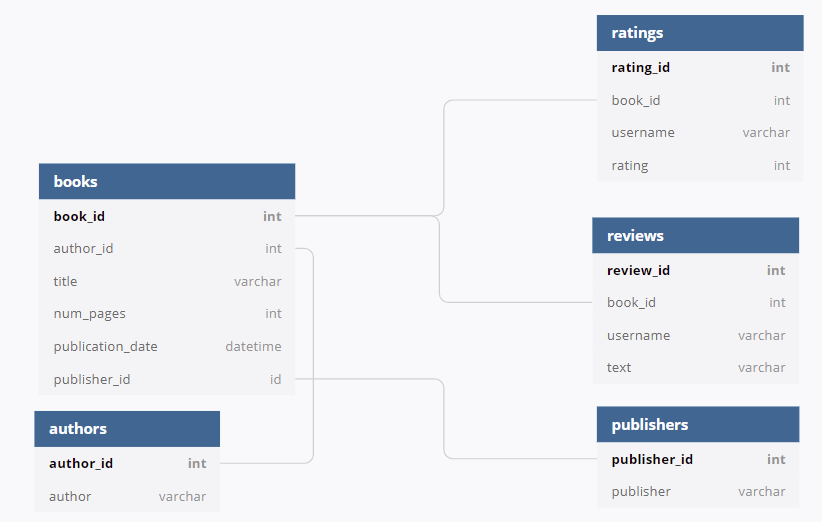

## Подготовка к работе

Импортируем необходимые библиотеки:

In [3]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

Установим настройки подключения к базе данных:

In [4]:
# устанавливаем параметры подключения к БД
db_config = {'user': 'praktikum_student', # имя пользователя
'pwd': 'Sdf4$2;d-d30pp', # пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения
'db': 'data-analyst-final-project-db'} # название базы данных

# Формируем строку соединения с БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
db_config['pwd'],
db_config['host'],
db_config['port'],
db_config['db'])

# сохраняем коннектор / # Подключаемся к БД.
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

Создадим функцию, которая выведен на экран нужное количество строк результата запроса и сохранит результат в датафрейм:

In [5]:
def response_to_query(query, n):   # принимаем sql-запрос и необходимое кол-во строк для вывода на экран
    # Выполняем запрос и сохраняем результат выполнения в DataFrame.
    df = pd.io.sql.read_sql(query, con = engine)
    print('Результат запроса содержит',len(df),'записей. Первые',n,'из них:')
    display(df.head(n))
    return df

Проверим как это работает:

In [6]:
df_1 = response_to_query(''' SELECT *
                               FROM books;
                        ''', 3)

Результат запроса содержит 1000 записей. Первые 3 из них:


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135


Поехали!

## Задание №1: "Посчитать, сколько книг вышло после 1 января 2000 года"

In [7]:
df_2 = response_to_query('''SELECT *
                              FROM books
                             WHERE publication_date >= '2000-01-01';''', 10)

Результат запроса содержит 821 записей. Первые 10 из них:


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268
5,6,257,1st to Die (Women's Murder Club #1),424,2005-05-20,116
6,7,258,2nd Chance (Women's Murder Club #2),400,2005-05-20,116
7,8,260,4th of July (Women's Murder Club #4),448,2006-06-01,318
8,9,563,A Beautiful Mind,461,2002-02-04,104
9,10,445,A Bend in the Road,341,2005-04-01,116


Ответ: 821 книг вышло после 1 января 2000 года.

## Задание №2 "Для каждой книги посчитать количество обзоров и среднюю оценку"

In [9]:
df_4 = response_to_query('''SELECT books.book_id, AU.author, books.title, RE.count_reviews, RA.mean_rating
                              FROM books
                         LEFT JOIN (SELECT book_id, COUNT(review_id) AS count_reviews
                                      FROM reviews 
                                     GROUP BY book_id) AS RE ON RE.book_id = books.book_id
                         LEFT JOIN (SELECT book_id, AVG(rating) AS mean_rating
                                      FROM ratings  
                                     GROUP BY book_id) AS RA ON RE.book_id = RA.book_id
                         LEFT JOIN (SELECT author_id, author
                                      FROM authors) AS AU ON AU.author_id = books.author_id;''', 10)

Результат запроса содержит 1000 записей. Первые 10 из них:


,book_id,author,title,count_reviews,mean_rating
0,1,Stephen King/Jerry N. Uelsmann,'Salem's Lot,2.0,3.666667
1,2,Patricia Schultz,1 000 Places to See Before You Die,1.0,2.500000
2,3,Maureen Johnson,13 Little Blue Envelopes (Little Blue Envelope...,3.0,4.666667
3,4,Charles C. Mann,1491: New Revelations of the Americas Before C...,2.0,4.500000
4,5,David McCullough,1776,4.0,4.000000
5,6,James Patterson,1st to Die (Women's Murder Club #1),4.0,3.500000
6,7,James Patterson/Andrew Gross,2nd Chance (Women's Murder Club #2),3.0,3.000000
7,8,James Patterson/Maxine Paetro,4th of July (Women's Murder Club #4),3.0,4.000000
8,9,Sylvia Nasar,A Beautiful Mind,2.0,4.250000
9,10,Nicholas Sparks,A Bend in the Road,3.0,3.200000


## Задача №3: "Определить издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры"

In [10]:
df_5 = response_to_query(''' SELECT BO.publisher_id, BO.count_book, PU.publisher
                               FROM (SELECT publisher_id, COUNT(book_id) AS count_book
                                       FROM books
                                      WHERE books.num_pages>50
                                      GROUP BY books.publisher_id
                                      ORDER BY count_book DESC) AS BO
                          LEFT JOIN (SELECT publisher_id, publisher
                                       FROM publishers) AS PU ON PU.publisher_id = BO.publisher_id
                           ORDER BY count_book DESC;''', 5)

Результат запроса содержит 334 записей. Первые 5 из них:


,publisher_id,count_book,publisher
0,212,42,Penguin Books
1,309,31,Vintage
2,116,25,Grand Central Publishing
3,217,24,Penguin Classics
4,35,19,Bantam


Ответ: Лидирует издательство "Penguin Books"

## Задача №4: "Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками"

Не совсем точно понятна задача, в данном случае отображены авторы с самыми высокими средними оценками каждой книги:

In [11]:
df_6 = response_to_query(''' SELECT books.book_id, books.author_id, AU.author, books.title, RA.mean_rating, RA.count_rating
                               FROM books
                         RIGHT JOIN (SELECT book_id, AVG(rating) AS mean_rating ,COUNT(rating) AS count_rating
                                       FROM ratings
                                   GROUP BY book_id
                                     HAVING ratings.count >= 50) AS RA ON RA.book_id = books.book_id
                          LEFT JOIN authors AS AU ON AU.author_id = books.author_id            
                           ORDER BY mean_rating DESC            
                              ''', 10)

Результат запроса содержит 19 записей. Первые 10 из них:


,book_id,author_id,author,title,mean_rating,count_rating
0,302,236,J.K. Rowling/Mary GrandPré,Harry Potter and the Prisoner of Azkaban (Harr...,4.414634,82
1,722,240,J.R.R. Tolkien,The Fellowship of the Ring (The Lord of the Ri...,4.391892,74
2,299,236,J.K. Rowling/Mary GrandPré,Harry Potter and the Chamber of Secrets (Harry...,4.287500,80
3,656,402,Markus Zusak/Cao Xuân Việt Khương,The Book Thief,4.264151,53
4,300,236,J.K. Rowling/Mary GrandPré,Harry Potter and the Half-Blood Prince (Harry ...,4.246575,73
5,399,376,Louisa May Alcott,Little Women,4.192308,52
6,301,236,J.K. Rowling/Mary GrandPré,Harry Potter and the Order of the Phoenix (Har...,4.186667,75
7,750,240,J.R.R. Tolkien,The Hobbit or There and Back Again,4.125000,88
8,779,498,Rick Riordan,The Lightning Thief (Percy Jackson and the Oly...,4.080645,62
9,405,621,William Golding,Lord of the Flies,3.901408,71


А теперь отобразим авторов с самыми высокими средними оценками всех выпущенных книг по каждому автору:

In [12]:
df_7 = response_to_query(''' SELECT authors.author_id, authors.author, BO.avg
                               FROM authors
                         RIGHT JOIN (SELECT books.author_id, avg(RA.mean_rating)
                                       FROM books
                                 RIGHT JOIN (SELECT book_id, AVG(rating) AS mean_rating ,COUNT(rating) AS count_rating
                                               FROM ratings
                                              GROUP BY book_id
                                             HAVING ratings.count >= 50) AS RA ON RA.book_id = books.book_id
                                   GROUP BY books.author_id
                                   ORDER BY avg DESC) AS BO ON BO.author_id=authors.author_id
                              ORDER BY BO.avg DESC           
                              ''', 10)

Результат запроса содержит 14 записей. Первые 10 из них:


,author_id,author,avg
0,236,J.K. Rowling/Mary GrandPré,4.283844
1,402,Markus Zusak/Cao Xuân Việt Khương,4.264151
2,240,J.R.R. Tolkien,4.258446
3,376,Louisa May Alcott,4.192308
4,498,Rick Riordan,4.080645
5,621,William Golding,3.901408
6,235,J.D. Salinger,3.825581
7,469,Paulo Coelho/Alan R. Clarke/Özdemir İnce,3.789474
8,630,William Shakespeare/Paul Werstine/Barbara A. M...,3.787879
9,106,Dan Brown,3.754540


В общем, в обоих вариантах лидирует автор J.K. Rowling/Mary GrandPré

## Задача №5: "Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок."

In [13]:
df_8 = response_to_query(''' SELECT AVG(RE.count_review)
                               FROM (SELECT username, COUNT(rating) AS count_ratings
                                       FROM ratings
                                      GROUP BY username
                                     HAVING ratings.count > 50) AS RA
                          LEFT JOIN (SELECT username, COUNT(review_id) AS count_review
                                       FROM reviews
                                   GROUP BY username)  AS RE ON RE.username =RA.username''', 10) 
                                

Результат запроса содержит 1 записей. Первые 10 из них:


,avg
0,24.333333


Среднее количество обзоров от пользователей, которые поставили больше 50 оценок составило 24,333 штук.

Спасибо за внимание!